In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

In [2]:
# Load the dataset
X_train = pd.read_csv('../outputs/01/X_train.csv', index_col='Unnamed: 0')
pred_train = pd.read_csv('../outputs/01/pred_train.csv', index_col='Unnamed: 0')
print(X_train.shape)
X_train.head()

(46913, 11)


,person_age,person_income,person_emp_length,loan_intent,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,home_own,home_mortgage
28905,22,53760,3.0,0.080694,4000,13.43,0.07,0,2,0,0
34862,22,26886,6.0,0.080694,7500,13.49,0.28,1,2,0,0
32740,26,57000,10.0,0.484107,3500,7.68,0.06,0,4,0,1
45780,23,48000,8.0,0.318378,5000,12.42,0.10,0,3,0,0
21826,34,62500,2.0,-0.266971,16000,10.99,0.26,0,7,0,1


In [ ]:
# Create anomaly model
anomaly_model = IsolationForest(n_estimators=100, contamination=0.01, random_state=123)
anomaly_category = anomaly_model.fit_predict(X_train)
anomaly = anomaly_model.decision_function(X_train)

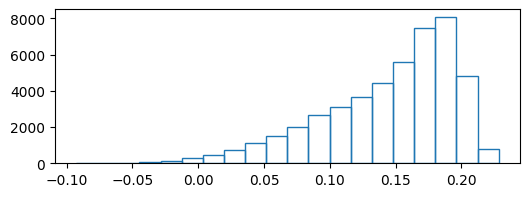

In [24]:
plt.figure(figsize=(6, 2))
plt.hist(anomaly, fill=False, edgecolor='tab:blue', bins=20)
plt.show()

In [44]:
data_anomaly = pd.concat([X_train, pred_train], axis=1)
data_anomaly['anomaly'] = anomaly
data_anomaly['anomaly_category'] = np.where(data_anomaly['anomaly'] < 0, 'outlier', 'inlier')
data_anomaly.head()

,person_age,person_income,person_emp_length,loan_intent,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,home_own,home_mortgage,probability,true,prediction,anomaly,anomaly_category
28905,22,53760,3.0,0.080694,4000,13.43,0.07,0,2,0,0,0.039574,0,0,0.196939,inlier
34862,22,26886,6.0,0.080694,7500,13.49,0.28,1,2,0,0,0.179108,0,0,0.114662,inlier
32740,26,57000,10.0,0.484107,3500,7.68,0.06,0,4,0,1,0.005868,0,0,0.161662,inlier
45780,23,48000,8.0,0.318378,5000,12.42,0.10,0,3,0,0,0.038395,0,0,0.201340,inlier
21826,34,62500,2.0,-0.266971,16000,10.99,0.26,0,7,0,1,0.032011,0,0,0.151201,inlier


In [45]:
data_anomaly['anomaly_category'].value_counts()

inlier     46443
outlier      470
Name: anomaly_category, dtype: int64

In [ ]:
# Save
data_anomaly[['anomaly', 'anomaly_category']].to_csv('../outputs/03/anomaly.csv')

In [ ]:
# anomaly = pd.read_csv('../outputs/03/anomaly.csv', index_col='Unnamed: 0')
# data_anomaly = pd.concat([X_train, pred_train, anomaly], axis=1)

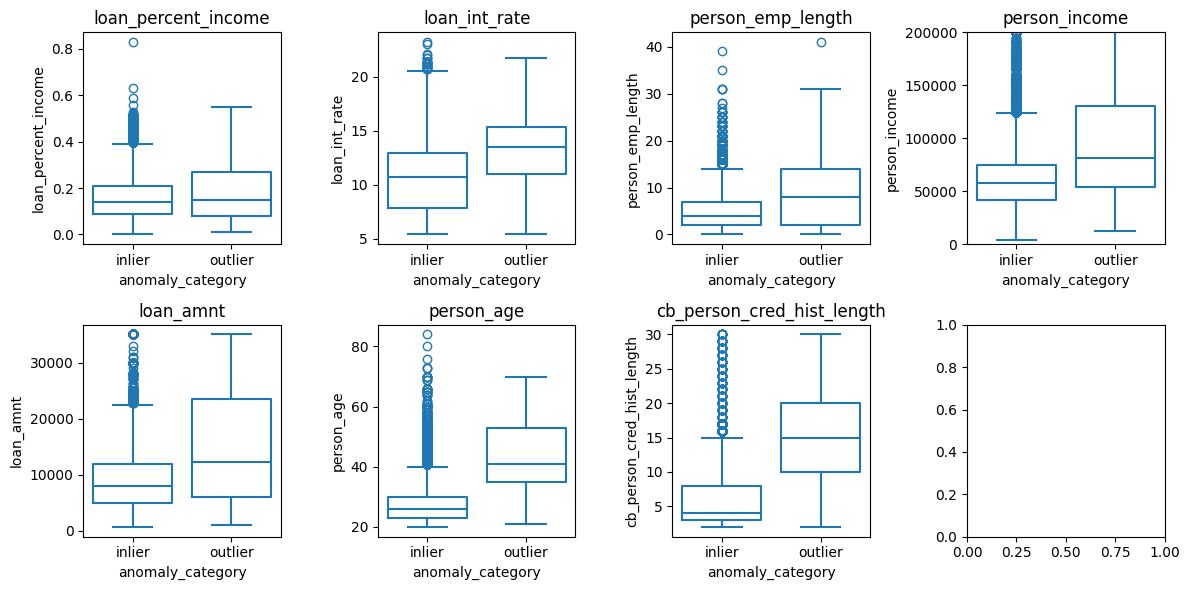

In [50]:
# Plot the count bars
fig, ax = plt.subplots(2, 4, figsize=(12,6))

row = 0
column = 0
for col in [
    'loan_percent_income', 'loan_int_rate', 'person_emp_length', 'person_income', 'loan_amnt',
    'person_age', 'cb_person_cred_hist_length'
]:
    sns.boxplot(data=data_anomaly, y=col, x='anomaly_category', ax=ax[row, column],  fill=False)
    ax[row, column].set_title(col)
    if col == 'person_income':
        ax[row, column].set_ylim(0, 2e5)
    
    column += 1
    if column == 4:
        column = 0
        row+= 1

plt.tight_layout()
plt.show()

In [61]:
col = 'true'
barplot = pd.DataFrame(data_anomaly[[col, 'anomaly_category']].value_counts()).reset_index()
barplot.columns = [col, 'anomaly_category', 'count']
barplot = barplot.pivot(index='anomaly_category', columns=col, values='count').reset_index()
barplot

true,anomaly_category,0,1
0,inlier,39852,6591
1,outlier,382,88


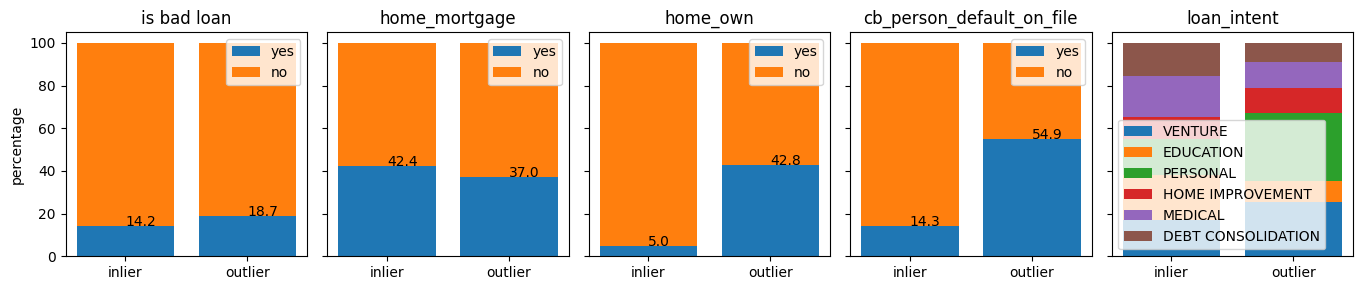

In [64]:
fig, ax = plt.subplots(1, 5, figsize=(14,3), sharey=True)

ax[0].set_ylabel('percentage')
column = 0
for col in ['true', 'home_mortgage', 'home_own', 'cb_person_default_on_file']:
    barplot = pd.DataFrame(data_anomaly[[col, 'anomaly_category']].value_counts()).reset_index()
    barplot.columns = [col, 'anomaly_category', 'count']
    barplot = barplot.pivot(index='anomaly_category', columns=col, values='count').reset_index()
    barplot.columns.name = None
    barplot = barplot.fillna(0)
    barplot['yes_percent'] = round(barplot[1] / (barplot[0] + barplot[1]) * 100, 1)
    barplot['no_percent'] = round(barplot[0] / (barplot[0] + barplot[1]) * 100, 1)
    
    ax[column].bar(barplot['anomaly_category'], barplot['yes_percent'], label='yes')
    ax[column].bar(barplot['anomaly_category'], barplot['no_percent'], bottom=barplot['yes_percent'], label='no')
    if col != 'true':
        ax[column].set_title(col)
    else:
        ax[column].set_title('is bad loan')
    ax[column].legend()
    for i in range(len(barplot)):
        percentage = barplot.loc[barplot.index==i, 'yes_percent'].values[0]
        ax[column].text(i, percentage, percentage)

    column += 1

# Plot the loan intent
col = 'loan_intent'
barplot = pd.DataFrame(data_anomaly[[col, 'anomaly_category']].value_counts()).reset_index()
barplot.columns = [col, 'anomaly_category', 'count']
barplot[col] = round(barplot[col], 2)
intent_dict = {0.48: 'VENTURE', 0.32: 'EDUCATION', 0.08: 'PERSONAL', -0.24: 'HOME IMPROVEMENT', -0.27: 'MEDICAL', -0.34: 'DEBT CONSOLIDATION'}
barplot[col] = barplot[col].map(intent_dict)

barplot = barplot.pivot(index='anomaly_category', columns=col, values='count').reset_index()
barplot.columns.name = None
barplot = barplot.fillna(0)
for intent in intent_dict.values():
    barplot[f'{intent}_percent'] = round(barplot[intent] / barplot[intent_dict.values()].sum(1) * 100, 1)

intent = 'VENTURE'
ax[column].bar(barplot['anomaly_category'], barplot[f'{intent}_percent'], label=intent)
bottom = barplot['VENTURE_percent']
for intent in list(intent_dict.values())[1:]:
    plt.bar(barplot['anomaly_category'], barplot[f'{intent}_percent'], bottom=bottom, label=intent)
    bottom = bottom + barplot[f'{intent}_percent']
ax[column].set_title('loan_intent')
ax[column].legend()

plt.tight_layout()
plt.show()

In [12]:
anomaly_samples = data_anomaly[
    (
        (data_anomaly['person_age'] >= 30) &
        (data_anomaly['cb_person_cred_hist_length']>10) &
        (data_anomaly['home_own'] == 1) &
        (data_anomaly['cb_person_default_on_file'] == 1)
    )
]
print(anomaly_samples.shape)
anomaly_samples.head()

(40, 16)


,person_age,person_income,person_emp_length,loan_intent,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,home_own,home_mortgage,probability,true,prediction,anomaly,anomaly_category
6323,38,65000,2.0,-0.236278,20000,13.92,0.31,1,15,1,0,0.066267,0,0,-0.008214,outlier
18534,36,55000,2.0,0.484107,12000,11.97,0.22,1,14,1,0,0.002141,0,0,-0.002273,outlier
50898,40,24449,2.0,0.318378,2000,12.84,0.08,1,12,1,0,0.004898,0,0,-0.009618,outlier
251,37,38400,8.0,0.318378,9600,13.61,0.25,1,17,1,0,0.003739,0,0,-0.014254,outlier
55004,41,35000,5.0,0.484107,10000,12.98,0.29,1,12,1,0,0.002186,0,0,-0.010256,outlier


Anomaly detection aims to identify the rare samples among the dataset. The Isolation Forest algorithm finds that 1% of the dataset samples have rare characteristics. Some of the anomaly samples are from borrowers who have defaulted loans in the past, but the recent loan has been paid off. Despite having past loan problems, the borrowers currently have higher incomes and apply for bigger loan amounts.